# 🏠 Airbnb Price Prediction Project

Ce projet a pour but de prédire le `log_price` des logements Airbnb à partir de leurs caractéristiques.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# Chargement des données
train = pd.read_csv(r"C:\Users\bouza\Desktop\projet1\Cours-Data-Science-M2\ML\Airbnb_Project\airbnb_train.csv")
test  = pd.read_csv(r"C:\Users\bouza\Desktop\projet1\Cours-Data-Science-M2\ML\Airbnb_Project\airbnb_test.csv")


## 🔍 Analyse exploratoire

In [17]:
# Valeurs manquantes
train.isnull().sum().sort_values(ascending=False)


host_response_rate        5475
review_scores_rating      4978
first_review              4725
last_review               4716
neighbourhood             2086
zipcode                    303
host_identity_verified      56
host_since                  56
host_has_profile_pic        56
bathrooms                   51
beds                        35
bedrooms                    26
description                  0
longitude                    0
property_type                0
room_type                    0
number_of_reviews            0
amenities                    0
name                         0
latitude                     0
city                         0
accommodates                 0
instant_bookable             0
bed_type                     0
cancellation_policy          0
log_price                    0
cleaning_fee                 0
id                           0
dtype: int64

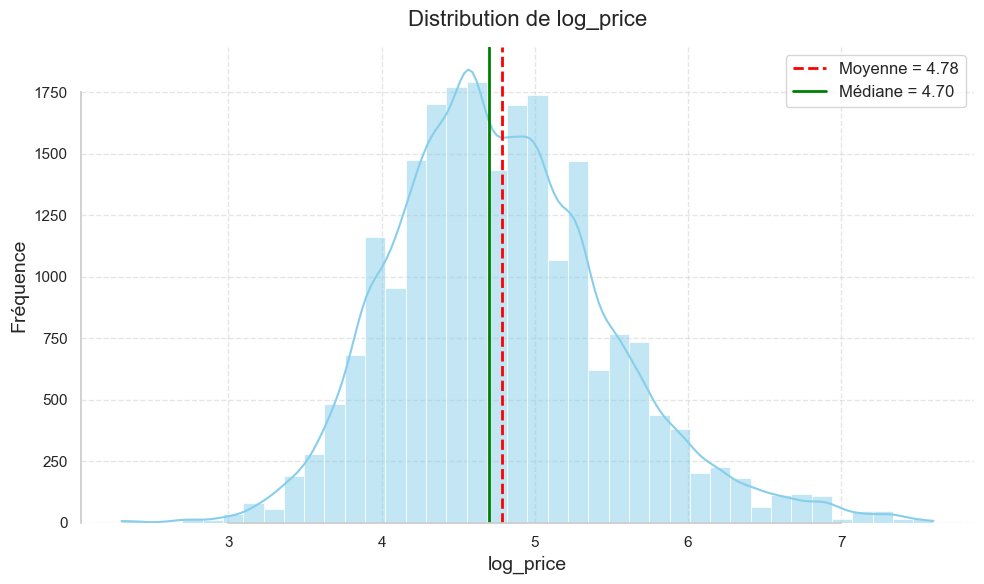

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_log_price_distribution(data, column='log_price', bins=40):
    """
    Affiche l’histogramme de la distribution de la colonne spécifiée,
    avec estimation de densité, lignes pour la moyenne et la médiane.
    """
    # Calculs statistiques
    values = data[column].dropna()
    mean_val = values.mean()
    median_val = values.median()
    
    # Style et figure
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Histogramme + KDE
    sns.histplot(values, kde=True, bins=bins, ax=ax, color="skyblue",
                 edgecolor="white", linewidth=0.5)
    
    # Lignes pour la moyenne et la médiane
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
               label=f"Moyenne = {mean_val:.2f}")
    ax.axvline(median_val, color='green', linestyle='-', linewidth=2,
               label=f"Médiane = {median_val:.2f}")
    
    # Titres et labels
    ax.set_title("Distribution de log_price", fontsize=16, pad=15)
    ax.set_xlabel("log_price", fontsize=14)
    ax.set_ylabel("Fréquence", fontsize=14)
    
    # Légende
    ax.legend(title=None, fontsize=12)
    
    # Amélioration de la lisibilité
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    sns.despine(trim=True)
    
    plt.tight_layout()
    plt.show()

# Exemple d’utilisation
plot_log_price_distribution(train)



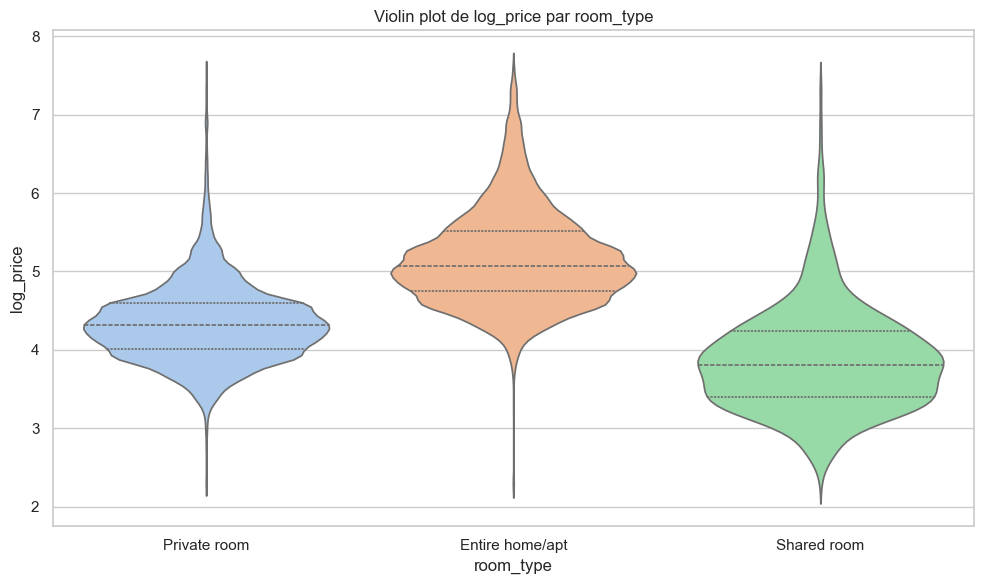

In [19]:
# 2. Violin plot de log_price par room_type
plt.figure(figsize=(10,6))
sns.violinplot(x='room_type', y='log_price', data=train, inner="quartile", palette="pastel")
plt.title("Violin plot de log_price par room_type")
plt.xlabel("room_type")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()


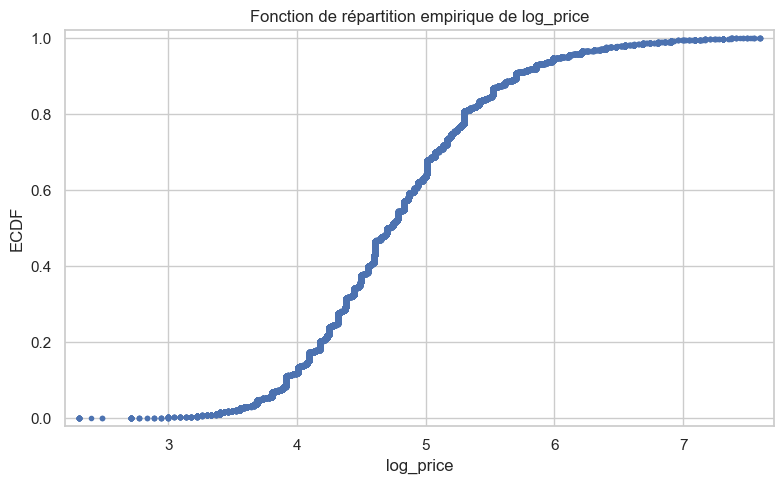

In [20]:
# 4. ECDF de log_price
x = np.sort(train['log_price'].dropna())
y = np.arange(1, len(x)+1) / len(x)
plt.figure(figsize=(8,5))
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel("log_price")
plt.ylabel("ECDF")
plt.title("Fonction de répartition empirique de log_price")
plt.margins(0.02)
plt.tight_layout()
plt.show()


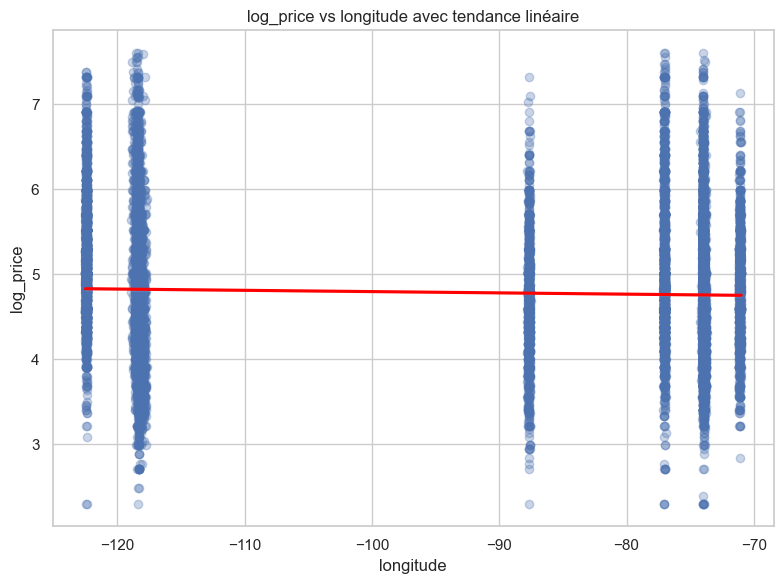

In [21]:
# 6. Scatter plot avec régression log_price vs longitude
plt.figure(figsize=(8,6))
sns.regplot(x='longitude', y='log_price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("log_price vs longitude avec tendance linéaire")
plt.xlabel("longitude")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()


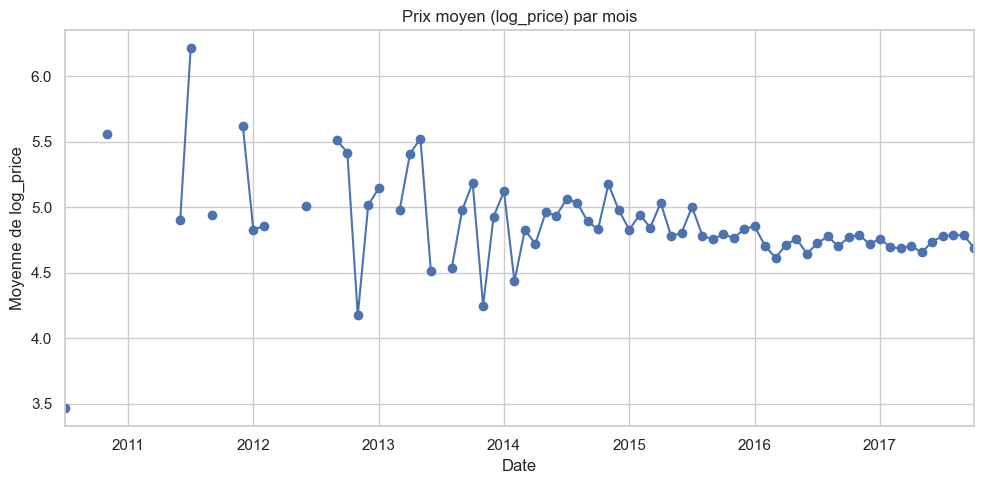

In [22]:
# 7. Série temporelle du log_price moyen par mois (à partir de last_review)
train['last_review'] = pd.to_datetime(train['last_review'])
ts = train.set_index('last_review')['log_price'].resample('M').mean()
plt.figure(figsize=(10,5))
ts.plot(marker='o')
plt.title("Prix moyen (log_price) par mois")
plt.xlabel("Date")
plt.ylabel("Moyenne de log_price")
plt.tight_layout()
plt.show()


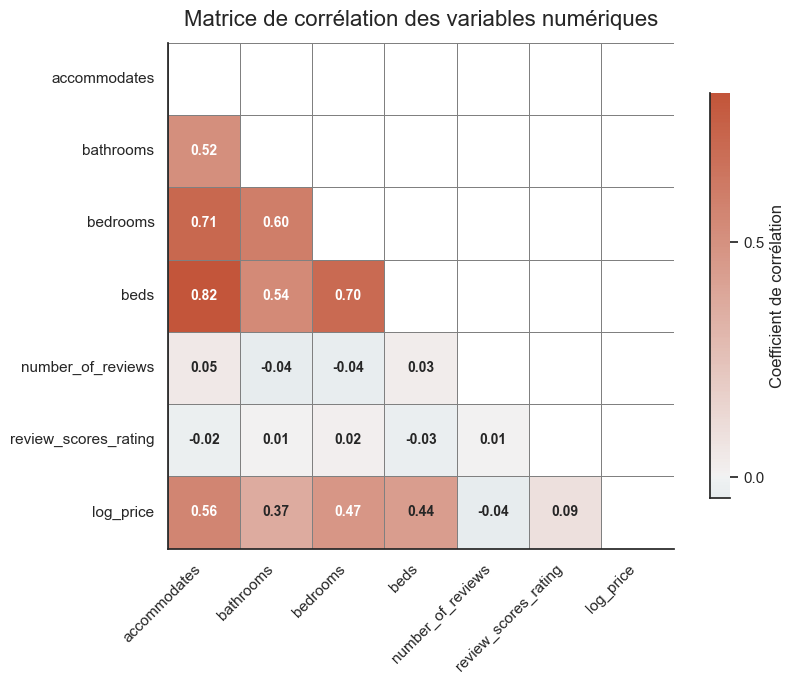

In [23]:
# Colonnes numériques à analyser
num_cols = [
    'accommodates', 'bathrooms', 'bedrooms',
    'beds', 'number_of_reviews', 'review_scores_rating', 'log_price'
]

# Calcul de la matrice de corrélation
corr = train[num_cols].corr()

# Masque pour n’afficher que la moitié inférieure
mask = np.triu(np.ones_like(corr, dtype=bool))

# Style général
sns.set_theme(style="white")

# Figure
fig, ax = plt.subplots(figsize=(9, 7))

# Palette divergeante : du bleu doux au rouge doux
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Tracé de la heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10, "weight": "bold"},
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={
        "shrink": 0.8,
        "ticks": [-1.0, -0.5, 0.0, 0.5, 1.0],
        "label": "Coefficient de corrélation"
    },
    square=True,
    center=0,
    ax=ax
)

# Titres et ajustements
ax.set_title("Matrice de corrélation des variables numériques", fontsize=16, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.show()


## 🧼 Prétraitement

In [24]:
bool_cols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified']
for col in bool_cols:
    train[col] = train[col].map({'t': 1, 'f': 0})
    test[col] = test[col].map({'t': 1, 'f': 0})

train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype(float)
test['host_response_rate'] = test['host_response_rate'].str.rstrip('%').astype(float)

train['cleaning_fee'] = train['cleaning_fee'].astype(int)
test['cleaning_fee'] = test['cleaning_fee'].astype(int)

train['host_since'] = pd.to_datetime(train['host_since'])
test['host_since'] = pd.to_datetime(test['host_since'])

train['host_since_days'] = (pd.to_datetime("2023-01-01") - train['host_since']).dt.days
test['host_since_days'] = (pd.to_datetime("2023-01-01") - test['host_since']).dt.days

train['has_wifi'] = train['amenities'].apply(lambda x: 1 if 'Wifi' in x or 'Wi-Fi' in x else 0)
test['has_wifi'] = test['amenities'].apply(lambda x: 1 if 'Wifi' in x or 'Wi-Fi' in x else 0)


## ⚙️ Modèle et pipeline

In [25]:
features = [
    'property_type', 'room_type', 'accommodates', 'bathrooms',
    'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
    'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
    'instant_bookable', 'latitude', 'longitude', 'number_of_reviews',
    'review_scores_rating', 'zipcode', 'bedrooms', 'beds',
    'host_since_days', 'has_wifi'
]

X = train[features]
y = train['log_price']
X_test_final = test[features]

num_vars = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_vars = X.select_dtypes(include='object').columns.tolist()

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_vars),
    ('cat', cat_pipe, cat_vars)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


## 📈 Entraînement et validation

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Split des données
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Entraînement
pipeline.fit(X_train, y_train)

# 3. Prédiction
y_pred = pipeline.predict(X_val)

# 4. Calcul du RMSE
mse = mean_squared_error(y_val, y_pred)     # retourne le MSE
rmse = np.sqrt(mse)                         # on en déduit le RMSE

print(f"✅ RMSE validation : {rmse:.4f}")


✅ RMSE validation : 0.4153


In [33]:
# Régression linéaire (Baseline)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lr_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('lr',      LinearRegression())
])

# Entraînement et évaluation
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"📝 Linear Regression RMSE : {rmse:.4f}")


📝 Linear Regression RMSE : 0.4299


In [34]:
#  Ridge Regression (L2 regularization)
from sklearn.linear_model import Ridge

ridge_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('ridge',   Ridge(alpha=1.0, random_state=42))
])

ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"🛡️  Ridge Regression RMSE : {rmse:.4f}")


🛡️  Ridge Regression RMSE : 0.4278


In [35]:
#  Lasso Regression (L1 regularization)
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('lasso',   Lasso(alpha=0.1, random_state=42, max_iter=5000))
])

lasso_pipeline.fit(X_train, y_train)
y_pred = lasso_pipeline.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"✂️  Lasso Regression RMSE : {rmse:.4f}")


✂️  Lasso Regression RMSE : 0.5585


In [36]:
#  k-Nearest Neighbors Regressor
from sklearn.neighbors import KNeighborsRegressor

knn_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('knn',     KNeighborsRegressor(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"👥 KNN Regressor RMSE : {rmse:.4f}")


👥 KNN Regressor RMSE : 0.5008


## 📤 Prédictions et export

In [29]:
final_predictions = pipeline.predict(X_test_final)

submission = pd.DataFrame({
    'id': test['Unnamed: 0'],
    'prediction': final_predictions
})
submission.to_csv("prediction.csv", index=False)
print("📁 Fichier prediction.csv généré avec succès !")


📁 Fichier prediction.csv généré avec succès !
